## Drug Review Sentiment Classifier - LLM

In [ ]:
# =============================
# 1. Imports
# =============================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import mlflow
import optuna

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import evaluate

from transformers import TrainingArguments
import inspect

print("Transformers version:", transformers.__version__)
print(inspect.signature(TrainingArguments.__init__))


/home/sandra/drug-review-sentiment/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# =============================
# 1. Load data
# =============================

train = pd.read_csv(os.path.join("..", "data", "drugsComTrain_raw.tsv"), sep="\t")
test = pd.read_csv(os.path.join("..", "data", "drugsComTest_raw.tsv"), sep="\t")


def create_label(rating):
    """
    Convert numeric rating (1 - 10) into binary label: 0 = negative, 1 = positive.
    """
    return 1 if rating > 5 else 0

train["sentiment"] = train["rating"].apply(create_label)
test["sentiment"]  = test["rating"].apply(create_label)

# Keep only required columns
train = train[["review", "sentiment"]]
test  = test[["review", "sentiment"]]

# Convert to Hugging Face datasets
train_ds = Dataset.from_pandas(train)
test_ds  = Dataset.from_pandas(test)

# Create DatasetDict
dataset = DatasetDict({
    "train": train_ds,
    "test": test_ds
})


In [3]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 161297
    })
    test: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 53766
    })
})


In [4]:
model_ckpt = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# Preprocess Data
def tokenize(batch):
    return tokenizer(batch["review"], truncation=True, padding="max_length", max_length=256)

tokenized = dataset.map(tokenize, batched=True)
tokenized = tokenized.remove_columns(["review"])
tokenized = tokenized.rename_column("sentiment", "labels")
tokenized.set_format("torch")


Map: 100%|██████████| 53766/53766 [00:08<00:00, 6142.24 examples/s]


In [9]:
# Training Setup
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

training_args = TrainingArguments(
    output_dir="results/biobert",

    # Defines when to run evaluation (trainer.evaluate).   
    # "epoch" → run evaluation at the end of every epoch. Alternatives: "steps" (every N steps) or "no".
    eval_strategy="epoch", 

    save_strategy="epoch", # when to save checkpoints
    learning_rate=2e-5, # Initial learning rate for AdamW optimizer.
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3, # Number of passes over the entire training dataset.
    weight_decay=0.01, # Regularization: penalizes large weights in the optimizer.
    load_best_model_at_end=True, # After training, reloads the best checkpoint (based on evaluation metric).
    logging_dir="logs", # Directory for logs (can be used with TensorBoard).
)

In [10]:
# Train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

# Evaluate
results = trainer.evaluate()
print(results)

/home/sandra/drug-review-sentiment/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

2025/09/11 22:31:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.8183, F1: 0.8626


Registered model 'DrugReviewSentiment' already exists. Creating a new version of this model...
Created version '3' of model 'DrugReviewSentiment'.


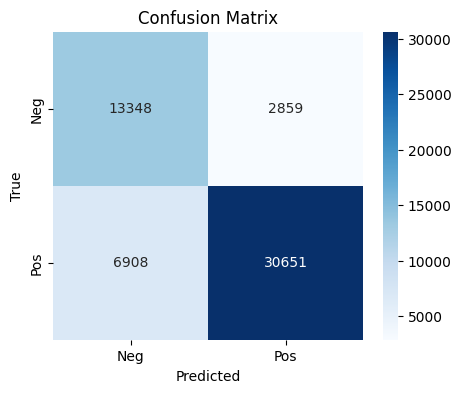

In [ ]:
# ========================================
# 3. Build pipeline and run it with MLFlow
# =======================================

mlflow.set_experiment("drug-review-sentiment")

with mlflow.start_run(run_name="logreg_tfidf_baseline"):

    # Pipeline
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words="english")),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log parameters
    mlflow.log_param("max_features", 5000)
    mlflow.log_param("ngram_range", (1,2))
    mlflow.log_param("C", pipeline.named_steps["clf"].C)

    # Log metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Save model
    mlflow.sklearn.log_model(pipeline, registered_model_name="DrugReviewSentiment")

    print(f"Accuracy: {acc:.4f}, F1: {f1:.4f}")

In [ ]:
# ===========================================
# Hyperpameter tunning
# ===========================================

def objective(trial):
    """
    Log experiments for hyperameter tunning using MLFlow and Optuna - bayesian optimizer
    """
    max_features = trial.suggest_int("max_features", 5000, 20000, step=5000)
    ngram_range_str = trial.suggest_categorical("ngram_range", ["(1,1)", "(1,2)", "(1,3)"])
    ngram_range = eval(ngram_range_str)  # safely parse into tuple
    C = trial.suggest_float("C", 1e-3, 1e2, log=True)

    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words="english")),
        ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear", C=C))
    ])

    # Cross-validation (5-fold)
    f1_scores = cross_val_score(pipeline, X_train, y_train,
                                cv=5, scoring="f1_weighted", n_jobs=-1)
    mean_f1 = f1_scores.mean()


    # log every trial to MLflow
    with mlflow.start_run(nested=True):
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("ngram_range", ngram_range)
        mlflow.log_param("C", C)
        mlflow.log_metric("cv_f1", mean_f1)

        # Log confusion matrix
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")

    return mean_f1

mlflow.set_experiment("drug-review-sentiment-optuna")

study = optuna.create_study(direction="maximize",
                            study_name="logreg_tfidf_f1cv",)

# Define baseline params
baseline_params = {
    "max_features": 5000,
    "ngram_range": "(1,2)",  # keep as string if you used string encoding
    "C": 1.0
}
# Enqueue baseline trial
study.enqueue_trial(baseline_params)

study.optimize(objective, n_trials=10)

print("Best params:", study.best_params)

[I 2025-09-11 22:24:57,788] A new study created in memory with name: no-name-c7c247ad-d6ed-4aae-8e95-e2248b9440cc
[I 2025-09-11 22:25:22,469] Trial 0 finished with value: 0.8216393016060891 and parameters: {'max_features': 5000, 'ngram_range': '(1,2)', 'C': 1.0}. Best is trial 0 with value: 0.8216393016060891.
[I 2025-09-11 22:25:52,288] Trial 1 finished with value: 0.82099882992076 and parameters: {'max_features': 5000, 'ngram_range': '(1,2)', 'C': 3.595340162669966}. Best is trial 0 with value: 0.8216393016060891.
[I 2025-09-11 22:26:16,235] Trial 2 finished with value: 0.7553205071385886 and parameters: {'max_features': 5000, 'ngram_range': '(1,2)', 'C': 0.0011945183652868913}. Best is trial 0 with value: 0.8216393016060891.
[I 2025-09-11 22:27:00,900] Trial 3 finished with value: 0.7887126807345661 and parameters: {'max_features': 5000, 'ngram_range': '(1,3)', 'C': 0.017133616121588213}. Best is trial 0 with value: 0.8216393016060891.
[I 2025-09-11 22:27:10,411] Trial 4 finished wi

Best params: {'max_features': 15000, 'ngram_range': '(1,2)', 'C': 92.99059302086661}


<Figure size 640x480 with 0 Axes>

In [ ]:
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("drug-review-sentiment-optuna")

# Get all runs
runs = client.search_runs(
    experiment_ids=[experiment.experiment_id],
    order_by=["metrics.f1 DESC"],  # sort by best f1
    max_results=1
)

best_run = runs[0]
best_params = best_run.data.params

print("Best Run ID:", best_run.info.run_id)
print("Best Params:", best_params)
print("Best Metrics:", best_run.data.metrics)

Best Run ID: 0584e77470f949d495ee02e4437503d8
Best Params: {'max_features': '5000', 'C': '0.013525523212128953', 'ngram_range': '(1, 3)'}
Best Metrics: {'accuracy': 0.7829855298887773, 'f1': 0.8347730040499589}


2025/09/11 22:30:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Best Model Logged! Accuracy=0.7830, F1=0.8348


Registered model 'DrugReviewSentiment' already exists. Creating a new version of this model...
Created version '2' of model 'DrugReviewSentiment'.


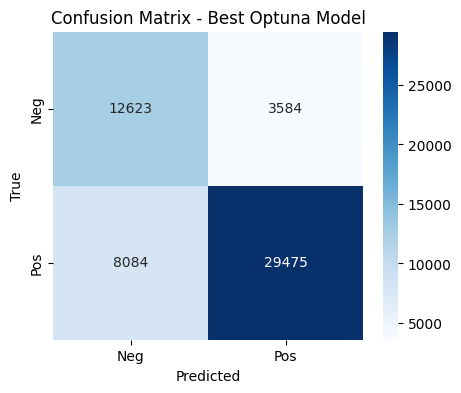

In [ ]:
# =============================
# 4. Train Best Model
# =============================
ngram_range = eval(best_params["ngram_range"])
max_features = int(best_params["max_features"])
C = float(best_params["C"])

best_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=max_features,
                              ngram_range=ngram_range,
                              stop_words="english")),
    ("clf", LogisticRegression(max_iter=200,
                               class_weight="balanced",
                               solver="liblinear",
                               C=C))
])

best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# =============================
# 5. Log Best Model to MLflow
# =============================
with mlflow.start_run(run_name="best_optuna_model"):
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1", f1)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
    plt.title("Confusion Matrix - Best Optuna Model")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Save Model
    mlflow.sklearn.log_model(best_pipeline, name="model",     
                             registered_model_name="DrugReviewSentiment")

print(f"✅ Best Model Logged! Accuracy={acc:.4f}, F1={f1:.4f}")

In [ ]:
import os
import pandas as pd
from mlflow.tracking import MlflowClient

# Ensure results folder exists
os.makedirs(os.path.join("..","results"), exist_ok=True)

# Get experiment
client = MlflowClient()
experiment = client.get_experiment_by_name("drug-review-sentiment-optuna")

# Fetch all runs
runs = client.search_runs([experiment.experiment_id])

# Convert to DataFrame
runs_df = pd.DataFrame([{
    "run_id": r.info.run_id,
    "status": r.info.status,
    "params": r.data.params,
    "metrics": r.data.metrics
} for r in runs])

# Flatten params + metrics into columns
def flatten_dict(d, prefix=""):
    return {f"{prefix}{k}": v for k, v in d.items()}

records = []
for r in runs:
    row = {
        "run_id": r.info.run_id,
        "status": r.info.status
    }
    row.update(flatten_dict(r.data.params, "param_"))
    row.update(flatten_dict(r.data.metrics, "metric_"))
    records.append(row)

flat_df = pd.DataFrame(records)

# Save both raw + flat versions
runs_df.to_json(os.path.join("..","results","mlflow_runs_raw.json"), orient="records", indent=2)
flat_df.to_csv(os.path.join("..","results","mlflow_runs.csv"), index=False)

print("✅ Exported MLflow runs to results/mlflow_runs.csv and results/mlflow_runs_raw.json")

✅ Exported MLflow runs to results/mlflow_runs.csv and results/mlflow_runs_raw.json
